# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [232]:
import pandas as pd
import numpy as np

from sklearn import datasets, linear_model, metrics
from sklearn.cross_validation import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import r2_score

## Load the data into a DataFrame
df = pd.read_csv('../Iowa_Liquor_sales_sample_10pct.csv')

## Transform the dates if needed, e.g.
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [233]:
print df.head()
df.shape
df.info()

        Date  Store Number         City Zip Code  County Number      County  \
0 2015-11-04          3717       SUMNER    50674            9.0      Bremer   
1 2016-03-02          2614    DAVENPORT    52807           82.0       Scott   
2 2016-02-11          2106  CEDAR FALLS    50613            7.0  Black Hawk   
3 2016-02-03          2501         AMES    50010           85.0       Story   
4 2015-08-18          3654      BELMOND    50421           99.0      Wright   

    Category              Category Name  Vendor Number  Item Number  \
0  1051100.0           APRICOT BRANDIES             55        54436   
1  1011100.0           BLENDED WHISKIES            395        27605   
2  1011200.0  STRAIGHT BOURBON WHISKIES             65        19067   
3  1071100.0         AMERICAN COCKTAILS            395        59154   
4  1031080.0             VODKA 80 PROOF            297        35918   

            Item Description  Bottle Volume (ml) State Bottle Cost  \
0  Mr. Boston Apricot Brandy

(270955, 18)

In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270955 entries, 0 to 270954
Data columns (total 18 columns):
date             270955 non-null datetime64[ns]
store_number     270955 non-null int64
city             270955 non-null object
zip_code         270955 non-null object
county_number    269878 non-null float64
county           269878 non-null object
cat_name         270323 non-null object
vendor           270955 non-null int64
item_number      270955 non-null int64
item_desc        270955 non-null object
btl_vol          270955 non-null int64
st_btl_cost      270955 non-null float64
st_btl_retail    270955 non-null float64
btls_sold        270955 non-null int64
sale             270955 non-null float64
vol_sold         270955 non-null float64
year             270955 non-null int64
month            270955 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(7), object(5)
memory usage: 37.2+ MB


In [249]:
print df.describe()

        store_number  county_number        vendor    item_number  \
count  270955.000000  269878.000000  270955.00000  270955.000000   
mean     3590.263701      57.231642     256.43443   45974.963300   
std       947.662050      27.341205     141.01489   52757.043086   
min      2106.000000       1.000000      10.00000     168.000000   
25%      2604.000000            NaN     115.00000   26827.000000   
50%      3722.000000            NaN     260.00000   38176.000000   
75%      4378.000000            NaN     380.00000   64573.000000   
max      9023.000000      99.000000     978.00000  995507.000000   

             btl_vol    st_btl_cost  st_btl_retail      btls_sold  \
count  270955.000000  270955.000000  270955.000000  270955.000000   
mean      924.830341       9.773281      14.675760       9.871285   
std       493.088489       7.047119      10.570145      24.040912   
min        50.000000       0.890000       1.340000       1.000000   
25%       750.000000       5.500000       

In [234]:
#Drop redundent data columns
df.drop('Volume Sold (Gallons)', axis=1, inplace=True)
df.drop('Category', axis=1, inplace=True)

#Rename columns
df.columns = ['date', 'store_number','city','zip_code','county_number','county',
              'cat_name','vendor','item_number','item_desc','btl_vol','st_btl_cost',
              'st_btl_retail','btls_sold','sale','vol_sold']

#Convert the data types of State Bottle Cost
df['sale'] = [float(x.replace('$','')) for x in df['sale']]
df['st_btl_cost'] = [float(x.replace('$','')) for x in df['st_btl_cost']]
df['st_btl_retail'] = [float(x.replace('$','')) for x in df['st_btl_retail']]

In [235]:
#Create new columns from month and year as numerical value. This will make it easier to filter Q1 sales data.
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

In [237]:
# I like to print the column names so I know the exact names what im working with.
df.columns.values

array(['date', 'store_number', 'city', 'zip_code', 'county_number',
       'county', 'cat_name', 'vendor', 'item_number', 'item_desc',
       'btl_vol', 'st_btl_cost', 'st_btl_retail', 'btls_sold', 'sale',
       'vol_sold', 'year', 'month'], dtype=object)

In [238]:
# Creating a pivot tables.
# Here I chose to create 3 pivot tables. Total data sales for 2015, Q1 2015 and Q1 2016 

pivot_2015 = pd.pivot_table(df[df['year'] == 2015], values=['sale'], index=['store_number'], columns=['year'], aggfunc=sum)
pivot_q1_2015 = df[(df['month'] < 4) & (df['year'] == 2015)]
pivot_q1_2016 = df[(df['month'] < 4) & (df['year'] == 2016)]

In [239]:
#Next, I chose to find the mean and sum of Bottles Sold, Volume Sold, Bottle Volume and State Retail Price for 2015

avg = pd.pivot_table(pivot_q1_2015, values=['sale', 'btls_sold', 'vol_sold', 'btl_vol', 'st_btl_retail'], 
                     index=['store_number'], columns=['year'])

q1_sales = pd.pivot_table(pivot_q1_2015, values=['sale', 'btls_sold', 'vol_sold'], 
                          index=['store_number'], columns=['year'], aggfunc=sum)
q12015 = pd.concat([avg, q1_sales], axis=1).dropna()

q12015.columns = [('avg sale', 'q1_2015'), ('avg btls_sold', 'q1_2015'), ('avg vol_sold', 'q1_2015'),
       ('avg btl_vol',  'q1_2015'), ('avg st_btl_retail', 'q1_2015'),
       ('total sale', 'q1_2015'), ('total btls_sold', 'q1_2015'), ('total vol_sold', 'q1_2015')]



In [240]:
#Next, I chose to find the mean and sum of Bottles Sold, Volume Sold, Bottle Volume and State Retail Price for 2016.
#Rename the column titles.

avg = pd.pivot_table(pivot_q1_2016, values=['sale', 'btls_sold', 'vol_sold', 'btl_vol', 'st_btl_retail'], index=['store_number'], columns=['year'])
q1_sales = pd.pivot_table(pivot_q1_2016, values=['sale', 'btls_sold', 'vol_sold'], index=['store_number'], columns=['year'], aggfunc=sum)

q12016 = pd.concat([avg, q1_sales], axis=1).dropna()
print q12016
q12016.columns = [('avg sale', 'q1_2016'), ('avg btls_sold', 'q1_2016'), ('avg vol_sold', 'q1_2016'),
       ('avg btl_vol',  'q1_2016'), ('avg st_btl_retail', 'q1_2016'),
       ('total sale', 'q1_2016'), ('total btls_sold', 'q1_2016'), ('total vol_sold', 'q1_2016')]


                    sale  btls_sold   vol_sold      btl_vol st_btl_retail  \
year                2016       2016       2016         2016          2016   
store_number                                                                
2106          240.344488  17.480315  16.675197   935.039370     15.614567   
2113           55.835135   4.297297   4.783784   986.486486     16.077297   
2130          238.086410  14.752137  13.306838   955.769231     15.932308   
2152           45.881000   4.533333   4.671000  1066.666667     12.711667   
2178           96.353448   8.275862   8.979310  1054.741379     13.915345   
2190          110.982926   8.254019   4.879293   798.472669     19.250836   
2191          331.036364  18.251748  20.476364  1009.440559     17.015245   
2200           50.913049   3.195122   3.887561  1084.756098     17.038780   
2228           46.763333   3.469697   3.164394   824.621212     15.306667   
2233          133.115306   9.755102   9.747347  1053.571429     22.361020   

In [241]:
# Here combine all of my features back into a single data frame. From here I can extract the data based on column name.
data = pd.concat([pivot_2015, q12015, q12016], axis=1).dropna()

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

In [242]:
data.columns.values

array([('sale', 2015), ('avg sale', 'q1_2015'),
       ('avg btls_sold', 'q1_2015'), ('avg vol_sold', 'q1_2015'),
       ('avg btl_vol', 'q1_2015'), ('avg st_btl_retail', 'q1_2015'),
       ('total sale', 'q1_2015'), ('total btls_sold', 'q1_2015'),
       ('total vol_sold', 'q1_2015'), ('avg sale', 'q1_2016'),
       ('avg btls_sold', 'q1_2016'), ('avg vol_sold', 'q1_2016'),
       ('avg btl_vol', 'q1_2016'), ('avg st_btl_retail', 'q1_2016'),
       ('total sale', 'q1_2016'), ('total btls_sold', 'q1_2016'),
       ('total vol_sold', 'q1_2016')], dtype=object)

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [243]:
from sklearn import linear_model, metrics
from sklearn.cross_validation import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import r2_score


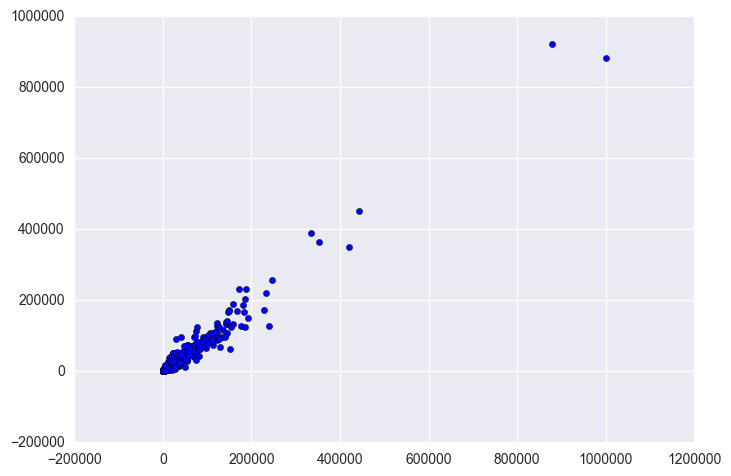

Cross-Predicted Accuracy: 0.965493720896


In [244]:
#First, I train my model using just total sales of Q1 2015 and total sales for 2015

lm = linear_model.LinearRegression()

X = data[[('total sale', 'q1_2015')]]
y = data[('sale', 2015)]

predictions = cross_val_predict(lm, X, y, cv=5)

model = lm.fit(X, predictions)
plt.scatter(y, predictions)
plt.show()
print "Cross-Predicted Accuracy:", model.score(X, y)

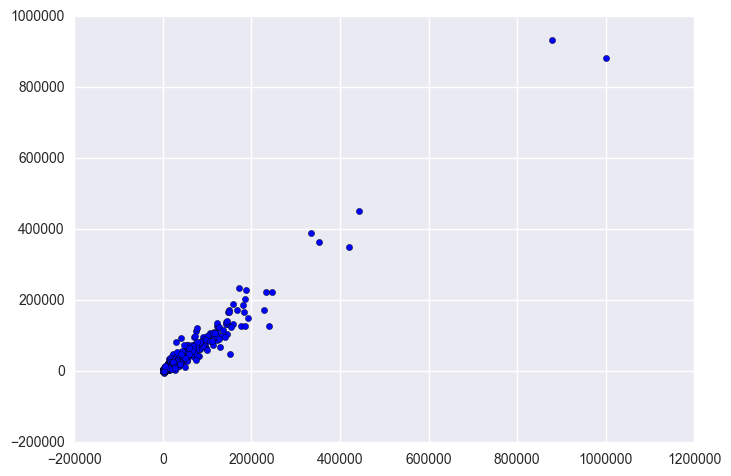

Cross-Predicted Accuracy: 0.966259879157


In [245]:
#Next, I added more features to see if I was able to train a better model. This resulted in a slightly higher R2.

lm = linear_model.LinearRegression()

X = data[[('avg btl_vol', 'q1_2015'), ('avg vol_sold', 'q1_2015'),
          ('total sale', 'q1_2015'), ('avg btls_sold', 'q1_2015')]]
y = data[('sale', 2015)]

predictions = cross_val_predict(lm, X, y, cv=5)

model = lm.fit(X, predictions)
plt.scatter(y, predictions)
plt.show()
print "Cross-Predicted Accuracy:", model.score(X, y)

In [246]:
# Predict 2016 sales using model
X = data[[('avg btl_vol', 'q1_2016'), ('avg vol_sold', 'q1_2016'),
          ('total sale', 'q1_2016'), ('avg btls_sold', 'q1_2016')]]
predictions = lm.predict(X)

Cross-Predicted Accuracy: 0.94014996295


In [262]:
predictions

array([ 133075.99733062,   10353.05809106,  122204.086728  , ...,
          1952.90698902,    5641.56648041,     758.8835836 ])

In [247]:
print sum(predictions)

27607603.7808


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

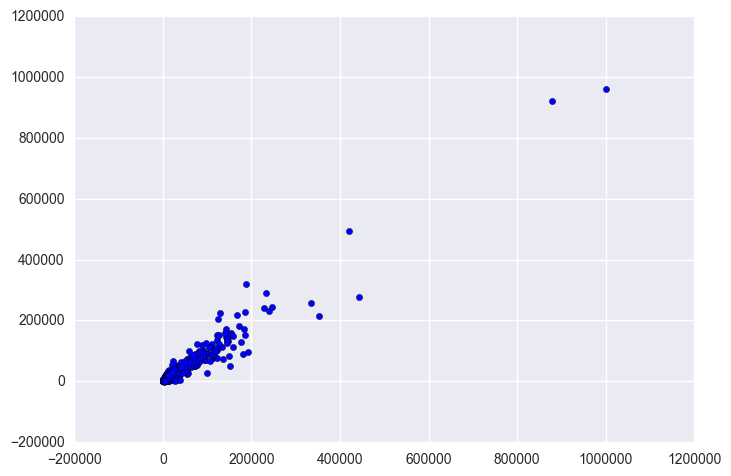

In [260]:
# Plots can be see above.
plt.scatter(y, predictions)
plt.show()

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.

In [ ]:
http://www.mattrussell.me/new-blog/2016/10/24/project-3-liquor-sales-linear-regression